# Step by step on training CNN using all bands info

### Library Loading

In [1]:
#pytorch lib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torch.utils.data import Dataset,random_split
import torch.optim as optim


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,shutil,warnings
import glob
import random 
import rasterio
import json

from tqdm import tqdm
from PIL import Image
from IPython.display import display
from torchvision import transforms
from typing import Tuple, Dict, List

from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


random.seed(69)


### Data Preparation

Since the task is Image Classification, using ImageFolder is very easy and hard to have some error, however Custom Dataset style is prefered if image is not format properly or preprocess step is complicated

### Data visualization

In [2]:
image_path = "datasets/EuroSATallBands/"
for dirpaths,dirnames,filenames in os.walk(image_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpaths}'.")

There are 11 directories and 5 images in 'datasets/EuroSATallBands/'.
There are 0 directories and 3000 images in 'datasets/EuroSATallBands/AnnualCrop'.
There are 0 directories and 2500 images in 'datasets/EuroSATallBands/Industrial'.
There are 0 directories and 3000 images in 'datasets/EuroSATallBands/Forest'.
There are 0 directories and 2000 images in 'datasets/EuroSATallBands/Pasture'.
There are 0 directories and 3000 images in 'datasets/EuroSATallBands/HerbaceousVegetation'.
There are 0 directories and 2500 images in 'datasets/EuroSATallBands/River'.
There are 0 directories and 2500 images in 'datasets/EuroSATallBands/Highway'.
There are 0 directories and 2500 images in 'datasets/EuroSATallBands/PermanentCrop'.
There are 0 directories and 3597 images in 'datasets/EuroSATallBands/SeaLake'.
There are 0 directories and 1 images in 'datasets/EuroSATallBands/.ipynb_checkpoints'.
There are 0 directories and 3000 images in 'datasets/EuroSATallBands/Residential'.


In [3]:
train_dir = os.path.join(image_path,"train")
test_dir = os.path.join(image_path,"test")
train_dir, test_dir

('datasets/EuroSATallBands/train', 'datasets/EuroSATallBands/test')

File: datasets/EuroSATallBands/Industrial/Industrial_1.tif
Width: 64
Height: 64
Number of bands: 13
CRS: EPSG:32632
Transform: | 10.00, 0.00, 323455.65|
| 0.00,-9.98, 5507072.62|
| 0.00, 0.00, 1.00|


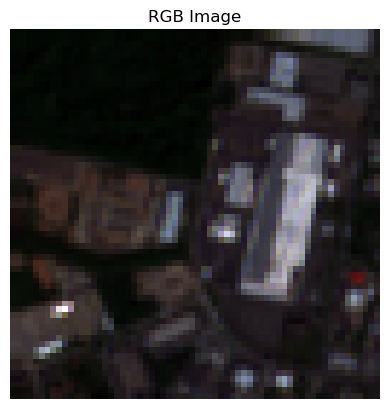

In [5]:
#View tif image using rasterio 
tiff_img = 'datasets/EuroSATallBands/Industrial/Industrial_1.tif'
with rasterio.open(tiff_img) as dataset:
    print(f"File: {tiff_img}")
    print(f"Width: {dataset.width}")
    print(f"Height: {dataset.height}")
    print(f"Number of bands: {dataset.count}")
    print(f"CRS: {dataset.crs}")
    print(f"Transform: {dataset.transform}")

    # Uncomment the below infos if you want to view infos in all bands
    # for band in range(1, dataset.count + 1):
    #     # Read the band data
    #     band_data = dataset.read(band)

    #Example of reading RGB from band
    red_band = dataset.read(4)   # Band 4
    green_band = dataset.read(3) # Band 3
    blue_band = dataset.read(2)  # Band 2
    
    def normalize(array):
        array_min, array_max = array.min(), array.max()
        return (array - array_min) / (array_max - array_min)

    #you can uncomment this to test what happened if not normalized properly
    red = normalize(red_band)
    green = normalize(green_band)
    blue = normalize(blue_band)

    # Stack the bands to create an RGB image
    rgb = np.dstack((red, green, blue))

    # Display the RGB image
    plt.imshow(rgb)
    plt.title('RGB Image')
    plt.axis('off')  # Hide the ax
    plt.show()


### Using Dataloader
Unlike ViT file, we use the DataLoader instead of ImageFolder since we've to preprocess the TIFF file instead of just use PNG/JPG file

In [6]:
# Converted all Tif into 6 band TIF file

tiff_image_path = glob.glob("datasets/EuroSATallBands/*/*.tif")
png_image_path = os.path.join("datasets/","EUROSATSixBands")
os.makedirs(png_image_path,exist_ok=True)

In [7]:
#helper fx
def normalize(arr):
    arr_min,arr_max = arr.min(),arr.max()
    return (arr-arr_min) / (arr_max-arr_min)

In [8]:
class EuroSATMultiBandDataset(Dataset):
    def __init__(self, img_dir , transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        #self.target_transform = target_transform

        with open(os.path.join(img_dir,"label_map.json"),"r") as file: 
            class_name_encoded = json.load(file)
        self.classes = list(class_name_encoded.keys())
        self.class_to_idx = {cls_name:idx for idx,cls_name in enumerate(self.classes)}

        for cls in self.classes:
            cls_dir = os.path.join(img_dir,cls)
            if os.path.isdir(cls_dir):
                for img_path in glob.glob(os.path.join(cls_dir,"*.tif")):
                    self.img_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls])

    def __getitem__(self,idx):

        img_path = self.img_paths[idx]
        label = self.labels[idx]
        with rasterio.open(img_path) as dataset:
            band2 = dataset.read(2)  # Blue
            band3 = dataset.read(3)  # Green
            band4 = dataset.read(4)  # Red
            band8 = dataset.read(8)  # NIR
            band11 = dataset.read(11) # SWIR1
            band12 = dataset.read(12) # SWIR2
    
            bands = [band2, band3, band4, band8, band11, band12]
            normalized_band = [normalize(band) for band in bands]
    
            #axis -1 for [h,w,vol], else it will be [vol,h,w]
            stacked_image = np.stack(normalized_band, axis =-1)
        if self.transform:
            stacked_image = self.transform(stacked_image)
        return stacked_image,label
        
    def __len__(self):
        return len(self.img_paths)

        
        
    

#### Test Dataloader 

In [9]:
root_dir = 'datasets/EuroSATallBands/'
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to a tensor and scales values to [0, 1]
    transforms.ConvertImageDtype(torch.float32),
])
dataset = EuroSATMultiBandDataset(root_dir, transform=transform)
sample_image, sample_label = dataset[0]
print(f"Image shape: {sample_image.shape}, Label: {sample_label}")



Image shape: torch.Size([6, 64, 64]), Label: 0


# Time to run our model

In [10]:
#initialized dataset
root_dir = 'datasets/EuroSATallBands/'
dataset = EuroSATMultiBandDataset(root_dir, transform=transform)


In [11]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [12]:
#initilized model
model = models.convnext_tiny(weights='DEFAULT')
model.features[0][0] = nn.Conv2d(6, 96, kernel_size=(4, 4), stride=(4, 4))
model.classifier[2] = nn.Linear(model.classifier[2].in_features,10)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/thanawit/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109M/109M [00:01<00:00, 100MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(6, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #print("test")
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        progress_bar.set_postfix(loss=running_loss/len(progress_bar))
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")
    if (epoch + 1) % 10 == 0:
        # 
        torch.save(model.state_dict(), f'weights/convnext_model_epoch_{epoch+1}.pth')

print("Finished Training")

Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:09<00:00, 11.20batch/s, loss=1.73]


Epoch [1/100], Loss: 1.7278683757843352


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:01<00:00, 12.62batch/s, loss=0.643]


Epoch [2/100], Loss: 0.6434735426034399


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:00<00:00, 12.80batch/s, loss=0.387]


Epoch [3/100], Loss: 0.3870914864762563


Epoch 4/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:01<00:00, 12.58batch/s, loss=0.29]


Epoch [4/100], Loss: 0.29034606938129304


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:00<00:00, 12.79batch/s, loss=0.239]


Epoch [5/100], Loss: 0.23945758524356814


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:58<00:00, 13.18batch/s, loss=0.201]


Epoch [6/100], Loss: 0.20055351470102062


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:59<00:00, 13.15batch/s, loss=0.164]


Epoch [7/100], Loss: 0.1637744410955341


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:58<00:00, 13.22batch/s, loss=0.136]


Epoch [8/100], Loss: 0.13554846005996107


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:59<00:00, 13.13batch/s, loss=0.116]


Epoch [9/100], Loss: 0.11643231897273291


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:58<00:00, 13.25batch/s, loss=0.102]


Epoch [10/100], Loss: 0.10173189502729024


Epoch 11/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:58<00:00, 13.29batch/s, loss=0.0836]


Epoch [11/100], Loss: 0.08358860781243696


Epoch 12/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:58<00:00, 13.29batch/s, loss=0.0779]


Epoch [12/100], Loss: 0.07788301402779489


Epoch 13/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:59<00:00, 13.16batch/s, loss=0.0619]


Epoch [13/100], Loss: 0.0618599804356575


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:59<00:00, 13.10batch/s, loss=0.057]


Epoch [14/100], Loss: 0.05701069606135017


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:00<00:00, 12.95batch/s, loss=0.055]


Epoch [15/100], Loss: 0.05502913172936314


Epoch 16/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:01<00:00, 12.71batch/s, loss=0.0524]


Epoch [16/100], Loss: 0.052371697850811395


Epoch 17/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:00<00:00, 12.93batch/s, loss=0.0533]


Epoch [17/100], Loss: 0.05325040726197591


Epoch 18/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:00<00:00, 12.89batch/s, loss=0.0414]


Epoch [18/100], Loss: 0.04137861148443836


Epoch 19/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:02<00:00, 12.45batch/s, loss=0.0425]


Epoch [19/100], Loss: 0.042520519188638625


Epoch 20/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:03<00:00, 12.24batch/s, loss=0.0384]


Epoch [20/100], Loss: 0.03838957987618403


Epoch 21/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:06<00:00, 11.62batch/s, loss=0.0367]


Epoch [21/100], Loss: 0.036727833721703095


Epoch 22/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:09<00:00, 11.12batch/s, loss=0.0414]


Epoch [22/100], Loss: 0.04138088192360145


Epoch 23/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:11<00:00, 10.87batch/s, loss=0.0342]


Epoch [23/100], Loss: 0.03422221367488502


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 777/777 [01:13<00:00, 10.52batch/s, loss=0.034]


Epoch [24/100], Loss: 0.0339512116562146


Epoch 25/100:   9%|████████▏                                                                                | 71/777 [00:37<10:30,  1.12batch/s, loss=0.00207]

In [20]:
model.load_state_dict(torch.load('weights/convnext_model_epoch_100.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)
val_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='Evaluating', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')


FileNotFoundError: [Errno 2] No such file or directory: 'weights/convnext_model_epoch_100.pth'

In [3]:
outputs.shape

NameError: name 'total' is not defined